In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvisa as visa
import time
plt.style.use('./figuras.mplstyle')


In [2]:
phi_k= 2.3 #ev
h=4.1*10**(-15)#ev*s

v_min_k=phi_k/h

c=2.998*10**(8) #m/s
lambda_min_k=c/v_min_k

lambda_min_k

m_a_nm=1*10**(9)
lambda_min_k_metros= m_a_nm*lambda_min_k
print(lambda_min_k_metros)

534.4260869565217


In [3]:
class SR830:
    '''Clase para el manejo amplificador Lockin SR830 usando PyVISA de interfaz'''

    scale_values = (2e-9, 5e-9, 10e-9, 20e-9, 50e-9, 100e-9, 200e-9, 500e-9, 1e-6,
                    2e-6, 5e-6, 10e-6, 20e-6, 50e-6, 100e-6, 200e-6, 500e-6, 1e-3,
                    2e-3, 5e-3, 10e-3, 20e-3, 50e-3, 100e-3, 200e-3, 500e-3, 1) # in V

    time_constant_values = (10e-6, 30e-6, 100e-6, 300e-6, 1e-3, 3e-3, 10e-3, 30e-3, 100e-3, 300e-3,
                    1e0, 3e0, 10e0, 30e0, 100e0, 300e0, 1e3, 3e3, 10e3, 30e3) # in s

    def __init__(self, resource):
        self._lockin = visa.ResourceManager().open_resource(resource)
        #print(self._lockin.query('*IDN?')) # habria que ver si es mejor no pedir IDN. Puede que trabe la comunicacion al ppio
        self._lockin.write("LOCL 2") #Bloquea el uso de teclas del Lockin
        time.sleep(1) # tal vez ayuda a evitar errores de comunicacion del pyvisa
        self.scale = self.get_scale()
        self.time_constant = self.get_time_constant()

    def __del__(self):
        self._lockin.write("LOCL 0") #Desbloquea el Lockin
        self._lockin.close()

    def set_modo(self, modo):
        '''Selecciona el modo de medición, A, A-B, I, I(10M)'''
        self._lockin.write("ISRC {0}".format(modo))

    def set_filtro(self, sen, tbase, slope):
        '''Setea el filtro de la instancia'''
        #Página 90 (5-4) del manual
        self._lockin.write("OFLS {0}".format(slope))
        self._lockin.write("OFLT {0}".format(tbase))
        self._lockin.write("SENS {0}".format(sen))

    def set_aux_out(self, auxOut = 1, auxV = 0):
        '''Setea la tensión de salida de al Aux Output indicado.
        Las tensiones posibles son entre -10.5 a 10.5'''
        self._lockin.write('AUXV {0}, {1}'.format(auxOut, auxV))

    def set_referencia(self,isIntern, freq, voltaje = 1):
        if isIntern:
            #Referencia interna
            #Configura la referencia si es así
            self._lockin.write("FMOD 1")
            self._lockin.write("SLVL {0:f}".format(voltaje))
            self._lockin.write("FREQ {0:f}".format(freq))
        else:
            #Referencia externa
            self._lockin.write("FMOD 0")

    def set_scale(self, scale_number):
        self.scale = min(scale_number,len(self.scale_values))
        self._lockin.write(f'SENS {self.scale}')
        return self.scale

    def setSensibility(self, sens):
        '''Setea la sensibilidad'''
        self._lockin.write(f"SENS {sens}")
    
    def get_scale(self):
        self.scale = int(self._lockin.query_ascii_values('SENS ?')[0])
        return self.scale

    def set_time_constant(self, time_constant_number):
        self._lockin.write(f'OFLT {time_constant_number}')
        self.time_constant = time_constant_number
        return self.time_constant

    def get_time_constant(self):
        return int(self._lockin.query_ascii_values('OFLT ?')[0])

    def set_display(self, isXY):
        if isXY:
            self._lockin.write("DDEF 1, 0") #Canal 1, x
            self._lockin.write('DDEF 2, 0') #Canal 2, y
        else:
            self._lockin.write("DDEF 1,1") #Canal 1, R
            self._lockin.write('DDEF 2,1') #Canal 2, T

    def get_display(self):
        '''Obtiene la medición que acusa el display.
        Es equivalente en resolución a la medición de los parámetros con SNAP?'''
        orden = "SNAP? 10, 11"
        return self._lockin.query_ascii_values(orden, separator=",")

    def get_medicion(self,isXY = True):
        '''Obtiene X,Y o R,Ang, dependiendo de isXY'''
        orden = "SNAP? "
        if isXY:
            self._lockin.write("DDEF 1,0") #Canal 1, XY
            orden += "1, 2" #SNAP? 1,2
        else:
            self._lockin.write("DDEF 1,1") #Canal 1, RTheta
            orden += "3, 4" #SNAP? 3, 4
        return self._lockin.query_ascii_values(orden, separator=",")

    def get_data(self):
        '''Obtiene X,Y o R,Ang, dependiendo de isXY'''
        orden = "SNAP? 1, 2, 3, 4"

        return self._lockin.query_ascii_values(orden, separator=",")
    
    def getMedicion(self, measurement_mode):
        '''
        Obtiene los valores medidos según measurement_mode:
            -'XY': Valores XY
            -'RT': Valores RT
            -Para otros valores, ver el manual. Es posible obtener
            hasta 6 valores simultáneamente.
        '''
        if measurement_mode=='XY':
            return self._lockin.query_ascii_values('SNAP? 1, 2', separator=',')
        elif measurement_mode=='RT':
            return self._lockin.query_ascii_values('SNAP? 3, 4', separator=',')
        else:
            print('No entendí lo que querés medir')
    def auto_scale(self):
        '''
            Utiliza medicion polar (r, angulo)
            inf_threshold es el porcentaje minimo de la escala  para el cual el
            autoescalado empiza a efectuarse: intenta mantenerse sobre ese rango. valor float de 0 a 1
        '''
        debug = True
        sup_theshold = 0.7
        inf_threshold = 0.1
        nespera = 5 # se recomienda esperar entre 3 y 5 veces el tiempo de medicion entre escalado y medicion
        tespera = self.time_constant_values[self.time_constant] * nespera
        time.sleep(tespera)
        r,tita = self.get_medicion(isXY=False)

     #   while r < self.scale_values[self.scale] * inf_threshold and self.scale > 0:
        while r < self.scale_values[self.scale] * inf_threshold:
            if debug:
                print('Valor por debajo de threshold, bajo escala (r=%g, oldscale=%g)'%(r,self.scale_values[self.scale]))
            self.scale -= 1
            self.set_scale(self.scale)
            time.sleep(tespera) # esperar N * el tiempo de integracion antes de medir
            r,tita = self.get_medicion(isXY=False)

       # while r > self.scale_values[self.scale] * sup_theshold and self.scale < (len(self.scale_values)-1):
        while r > self.scale_values[self.scale] * sup_theshold:

            if debug:
                print('Overloaded, subo escala (oldscale=%g)'%(self.scale_values[self.scale]))
            self.scale += 1
            self.set_scale(self.scale)
            time.sleep(tespera)
            r,tita = self.get_medicion(isXY=False)

        if debug:
            print('Listo (r=%g, scale=%g)'%(r, self.scale_values[self.scale]))
            print(f'La cuenta de escalado min da:{self.scale_values[self.scale] * inf_threshold}')
            print(f'La cuenta de escalado max da: {self.scale_values[self.scale] * sup_theshold}')
            print(f'Booleano de escala minima:{r < self.scale_values[self.scale] * inf_threshold}')
            print(f'Booleano de escala minima: {self.scale > 0}')
            

        return r, tita
    

In [4]:
#Puedo solucionar?
list_sens = [2e-9,5e-9,10e-9,20e-9,50e-9,100e-9,200e-9,500e-9,1e-6,2e-6,5e-6,10e-6,20e-6,50e-6,100e-6,200e-6,500e-6,1e-3,2e-3,5e-3,10e-3,20e-3,50e-3,100e-3,200e-3,500e-3,1]
def closest_value_index(array, A):
    absolute_diff = [abs(i - 2.5*A) for i in array]
    closest_index = absolute_diff.index(min(absolute_diff))
    return closest_index

def def_sens2(lista):
    med = li.getMedicion('RT')[0]
    i = closest_value_index(list_sens,med)
    return i


In [5]:
rm = visa.ResourceManager()
rm.list_resources()

('ASRL1::INSTR',
 'ASRL2::INSTR',
 'ASRL3::INSTR',
 'ASRL10::INSTR',
 'ASRL11::INSTR',
 'GPIB0::8::INSTR')

In [6]:
# Habilito la conexión
rm = visa.ResourceManager()
rm.list_resources()
#generador = rm.list_resources()[5]
lock_in = rm.list_resources()[5]
filtro = rm.list_resources()[4]
#print(instrumentos)
#fungen = rm.open_resource(generador)
fil = rm.open_resource(filtro)
lock = rm.open_resource(lock_in)

addr_lockin = lock_in

li = SR830(addr_lockin)

#fungen.query('*IDN?')
#fil.query('*IDN?')


#fil.query('SP?') #PREGUNTO EL RANGO MAXIMO Y MINIMO DE LONG DE ONDAS QUE FILTRA

In [76]:
li.set_aux_out(auxOut = 1, auxV =1) #seteo el voltaje enviado

Text(0.5, 1.0, 'Corriente en función del voltaje retardador')

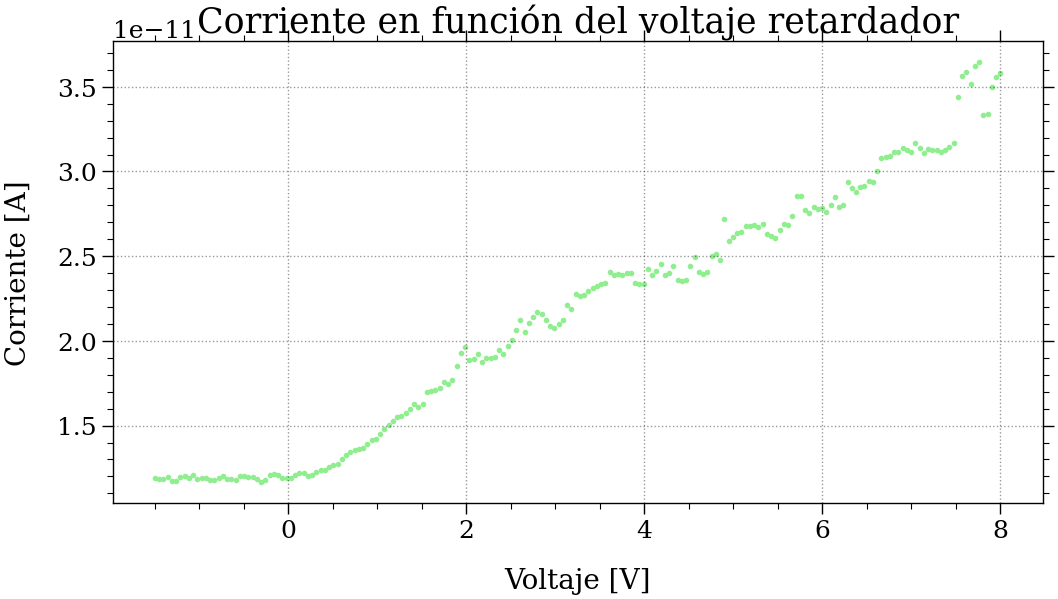

In [74]:
#PARA MEDIR CORRIENTE
x_comp = []
y_comp = []
amplitud = []
desfasaje = []
escala_t = []
escala_amp = []
voltajes = np.linspace(-1.5, 8, 200) #DETERMINO LOS VALORES DE V's A TOMAR DATOS

ti = 1 #Tiempo de integracion
l_onda = 476
frec_señal = 2.023

li.set_modo('I') #Selecciona el modo de medición, A, A-B, I, I(10M)


for volts in voltajes:

  li.set_aux_out(auxOut = 1, auxV = volts) #seteo el voltaje enviado
  #li.setSensibility(def_sens2(volts)) #Se cambia en cada iteración, definición de la función más arriba
  time.sleep(3) #Por las dudas enchufo tiempo de espera

  dato = li.get_data() #TOMO LOS DATOS DE R Y THETA (AHORA R ES LA CORRIENTE)
  #dato = li.auto_scale()
  esc_t = li.get_time_constant() #TOMO LA POSICION CORRESPONDIENTE A LA ESCALA EN EL VECTOR DE TIME CONSTANTS
  esc_amp = li.get_scale() #TOMO LA POSICION CORRESPONDIENTE A LA ESCALA EN EL VECTOR DE SCALE VALUES

  #Si auto_scale no tira datos, se puede usar el get_data u elegir el theta y R directamente

  x = dato[0]
  y = dato[1]
  amp = dato[2] #Amplitud de la corriente
  fas = dato[3] #el desfasaje no es importante

  #Appendeo todo en las listas que cree arriba
  x_comp.append(x)
  y_comp.append(y)
  amplitud.append(amp)
  desfasaje.append(fas)
  escala_t.append(esc_t)
  escala_amp.append(esc_amp)

# GUARDAR DATOS

df = pd.DataFrame()
df['Potencial Retardador'] = voltajes
df['Corriente'] = amplitud
df['Desfasaje'] = desfasaje
df['X'] = x_comp
df['Y'] = y_comp
df['EscTemporal'] = escala_t
df['EscAmplitud'] = escala_amp
df['Fecha de medicion'] = pd.Series([time.ctime()],index = [0])
df['Tiempo Integracion'] = pd.Series([{ti}],index = [0])
df['Frec de Señal'] = pd.Series([{frec_señal}],index = [0])
df['Tiempo de espera'] = pd.Series([3],index = [0] )


# if input('Queres guardar? [y/n]') == 'y':

df.to_csv(rf'Mediciones Dia 3\barrido_2.5V, {voltajes[0]} a {voltajes[-1]}, lamda={l_onda}, ti = {ti}s.csv')

#PLOTEAMOS
fig, ax = plt.subplots()

ax.plot(voltajes,np.array(amplitud),'.',alpha= 1, zorder=0)

ax.set_xlabel('Voltaje [V]', fontsize=20)
ax.set_ylabel('Corriente [A]', fontsize=20)
# plt.title('Espectro recibido al emitir '+str(long)+' nm', fontsize=30)
ax.set_title('Corriente en función del voltaje retardador', fontsize=25)



In [42]:
print(dato)

[1.73835e-11, -1.44756e-11, 2.26202e-11, -39.78]


In [15]:
# GUARDAR DATOS
df = pd.DataFrame()
df['Potencial Retardador'] = voltajes
df['Corriente'] = amplitud
df['Desfasaje'] = desfasaje
df['EscTemporal'] = escala_t
df['EscAmplitud'] = escala_amp
# if input('Queres guardar? [y/n]') == 'y':

df.to_csv(rf'Mediciones Dia 3\barrido_escaleadoAmano, {voltajes[0]} a {voltajes[-1]}, lamda={l_onda}, ti = {ti}s.csv')


ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

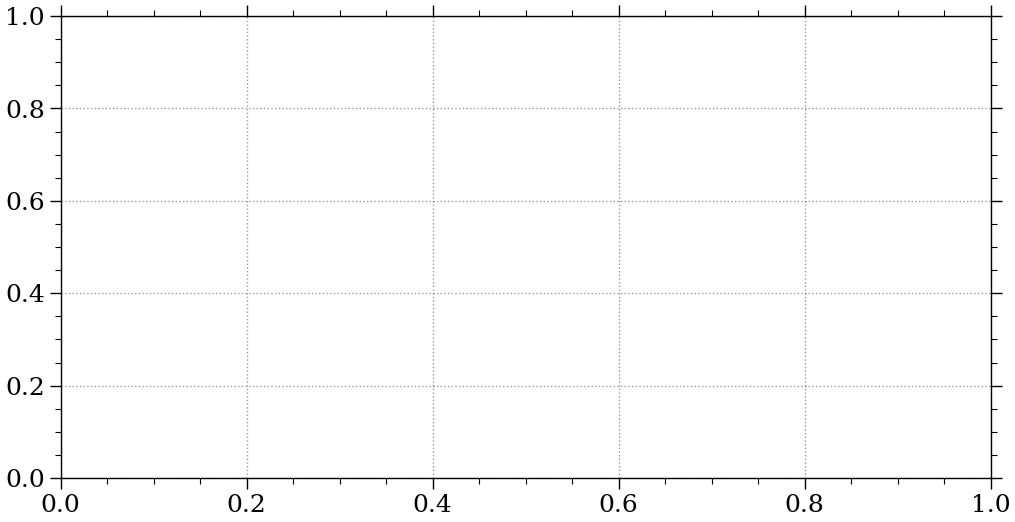

In [28]:
fig, ax = plt.subplots()

ax.plot(voltajes,-np.array(amplitud),'.',alpha= 1, color='cornflowerblue', zorder=0)

ax.set_xlabel('Voltaje [V]', fontsize=20)
ax.set_ylabel('Corriente [A]', fontsize=20)
# plt.title('Espectro recibido al emitir '+str(long)+' nm', fontsize=30)
ax.set_title('Corriente en función del voltaje retardador', fontsize=25)



In [ ]:

#CODIGOS DE FILTRO Para usar

fil.write('OM=n') #SETEA EN ALGUNO DE LOS SIG MODOS: n=1: MANUAL, n=2: SEQUENCE (internal clock), n=3: SEQUENCE (external triggered), n=4: ANALOG (internal clock), n=5: ANALOG (external triggered)
fil.query('OM?') #PREGUNTO EL MODO

fil.write('BW=n') #PONGO EL MODO DEL BANWITDH : n=1: BLACK mode, n=2: WIDE mode
fil.write('WL=n;') #SETEA EL FILTRO EN LA LONG DE ONDA N (CON N ENTRE LOS LIMITES DEL FILTRO)
#%%
#PARA MEDIR CORRIENTE
amplitud = []
desfasaje = []
escala_t = []
escala_amp = []
voltajes = np.linspace(-3, 3, 50) #DETERMINO LOS VALORES DE V's A TOMAR DATOS

li.set_modo('I') #Selecciona el modo de medición, A, A-B, I, I(10M)


for volts in voltajes:

  li.set_aux_out(auxOut = 1, auxV = volts) #seteo el voltaje enviado

  time.sleep(3) #Por las dudas enchufo tiempo de espera

  dato = li.get_data() #TOMO LOS DATOS DE R Y THETA (AHORA R ES LA CORRIENTE)
  esc_t = li.get_time_constant() #TOMO LA POSICION CORRESPONDIENTE A LA ESCALA EN EL VECTOR DE TIME CONSTANTS
  esc_amp = li.get_scale() #TOMO LA POSICION CORRESPONDIENTE A LA ESCALA EN EL VECTOR DE SCALE VALUES

  #Si auto_scale no tira datos, se puede usar el get_data u elegir el theta y R directamente


  amp = dato[0] #Amplitud de la corriente
  fas = dato[1] #el desfasaje no es importante

  #Appendeo todo en las listas que cree arriba
  amplitud.append(amp)
  desfasaje.append(fas)
  # escala_t.append(esc_t)
  # escala_amp.append(esc_amp)


df = pd.DataFrame(dict(Amplitud=amplitud, Desfasaje=desfasaje, Voltaje=voltajes)) #, EscTemporal=escala_t, EscAmplitud=escala_amp))
df.to_pickle("Fotoelectrico_CORRIENTE (680 nm)_.pandas")


plt.plot(voltajes,-np.array(amplitud),'.',alpha= 1, color='b', zorder=0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Voltaje [V]', fontsize=20)
plt.ylabel('Corriente [pA]', fontsize=20)
# plt.title('Espectro recibido al emitir '+str(long)+' nm', fontsize=30)
plt.title('Corriente en función del voltaje retardador', fontsize=25)
plt.grid()
plt.show()



#%% 
#PARA MEDIR VOLTAJE 
amplitud = []
desfasaje = []
escala_t = []
escala_amp = []
#lambdas = np.linspace(100, 1000, 9) #DETERMINO LOS VALORES DE LONG DE ONDA A TOMAR DATOS

for lamb in lambdas:

#    fil.write('WL= {:f}'.format(lamb) ) #Elijo la longitud de onda del filtro
    time.sleep(2) #Por las dudas enchufo tiempo de espera

    dato = li.auto_scale() #TOMO LOS DATOS DE R Y THETA
    esc_t = li.get_time_constant() #TOMO LA POSICION CORRESPONDIENTE A LA ESCALA EN EL VECTOR DE TIME CONSTANTS
    esc_amp = li.get_scale() #TOMO LA POSICION CORRESPONDIENTE A LA ESCALA EN EL VECTOR DE SCALE VALUES

    #Si auto_scale no tira datos, se puede usar el get_data u elegir el theta y R directamente


    amp = dato[0]
    fas = dato[1]

    #Appendeo todo en las listas que cree arriba
    amplitud.append(amp)
    desfasaje.append(fas)
    escala_t.append(esc_t)
    escala_amp.append(esc_amp)


df = pd.DataFrame(dict(Amplitud=amplitud, Desfasaje=desfasaje, LongOnda=lambdas, EscTemporal=escala_t, EscAmplitud=escala_amp))
df.to_pickle("Fotoelectrico_LONGONDA_.pandas")

fUNCION TRABAJO


Text(0.5, 1.0, 'Corriente en función del voltaje retardador')

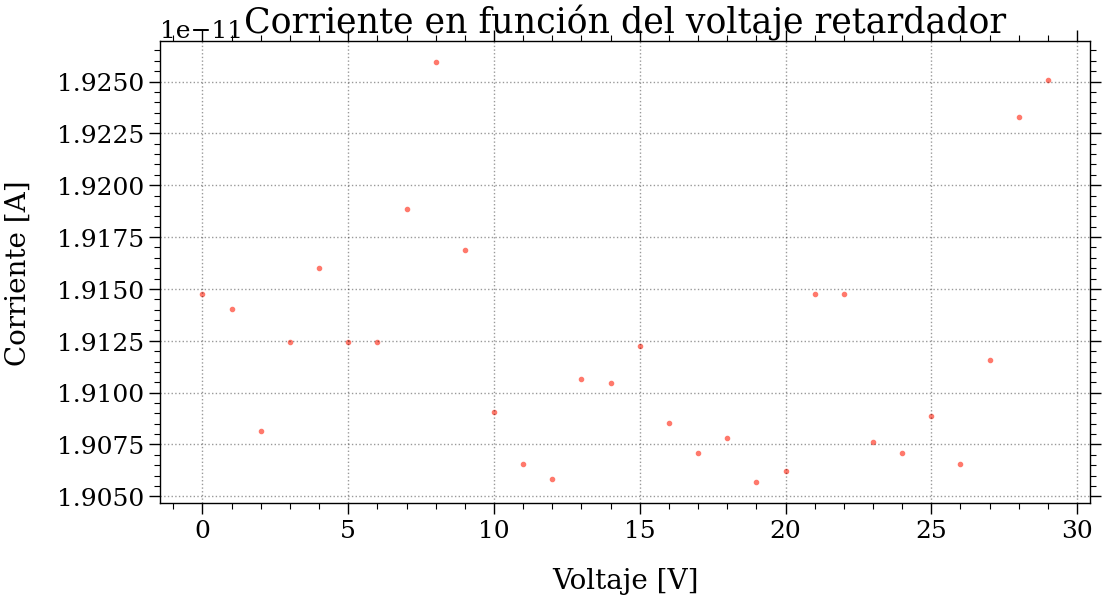

In [104]:
#PARA MEDIR CORRIENTE
x_comp = []
y_comp = []
amplitud = []
desfasaje = []
escala_t = []
escala_amp = []
#voltajes = np.linspace(-1.5, 8, 200) #DETERMINO LOS VALORES DE V's A TOMAR DATOS

ti = 1 #Tiempo de integracion
l_onda = 686
frec_señal = 2.023

li.set_modo('I') #Selecciona el modo de medición, A, A-B, I, I(10M)


for i in range(30):

  #li.set_aux_out(auxOut = 1, auxV = volts) #seteo el voltaje enviado
  #li.setSensibility(def_sens2(volts)) #Se cambia en cada iteración, definición de la función más arriba
  time.sleep(1) #Por las dudas enchufo tiempo de espera

  dato = li.get_data() #TOMO LOS DATOS DE R Y THETA (AHORA R ES LA CORRIENTE)
  #dato = li.auto_scale()
  esc_t = li.get_time_constant() #TOMO LA POSICION CORRESPONDIENTE A LA ESCALA EN EL VECTOR DE TIME CONSTANTS
  esc_amp = li.get_scale() #TOMO LA POSICION CORRESPONDIENTE A LA ESCALA EN EL VECTOR DE SCALE VALUES

  #Si auto_scale no tira datos, se puede usar el get_data u elegir el theta y R directamente

  x = dato[0]
  y = dato[1]
  amp = dato[2] #Amplitud de la corriente
  fas = dato[3] #el desfasaje no es importante

  #Appendeo todo en las listas que cree arriba
  x_comp.append(x)
  y_comp.append(y)
  amplitud.append(amp)
  desfasaje.append(fas)
  escala_t.append(esc_t)
  escala_amp.append(esc_amp)

# GUARDAR DATOS

df = pd.DataFrame()
df['Corriente'] = amplitud
df['Desfasaje'] = desfasaje
df['X'] = x_comp
df['Y'] = y_comp
df['EscTemporal'] = escala_t
df['EscAmplitud'] = escala_amp
df['Fecha de medicion'] = pd.Series([time.ctime()],index = [0])
df['Tiempo Integracion'] = pd.Series([{ti}],index = [0])
df['Frec de Señal'] = pd.Series([{frec_señal}],index = [0])
df['Tiempo de espera'] = pd.Series([3],index = [0] )
df['Volt al LED'] = pd.Series([5],index = [0] )
df['Potencial Retardador'] = pd.Series([1],index = [0])



# if input('Queres guardar? [y/n]') == 'y':

df.to_csv(rf'Mediciones Dia 3\funcion trabajo, lamda={l_onda}, ti = {ti}s.csv')

#PLOTEAMOS
fig, ax = plt.subplots()

ax.plot(range(30),np.array(amplitud),'.',alpha= 1, zorder=0,color = 'C3')

ax.set_xlabel('Voltaje [V]', fontsize=20)
ax.set_ylabel('Corriente [A]', fontsize=20)
# plt.title('Espectro recibido al emitir '+str(long)+' nm', fontsize=30)
ax.set_title('Corriente en función del voltaje retardador', fontsize=25)